In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math

from gurobipy import GRB
from itertools import chain
from matplotlib import cm
from utils import file_reader as fr
from utils import data_generator as dg
from utils import problem_model as pm
from utils import data_visualizer as dv


# Extra

In this part we try to add some further considerations about the models studied so far

## About agents' symmetry

In section 3.4 the authors of the paper said:
>    _"Of note, the increased convergence time may be a result of not only the increase in problem size,
>    but added symmetry within the problem between the homogeneous agents with identical source and termini nodes."_

In this part we investigate if lowering the symmetry between agents' sources and termini will speed-up the problem solutions for different levels of network congestion.  
Three different levels of agent simmetries will be considered:

- _high_: on which all agents have the same sources and termini (located in the first and last columns respectively)

- _medium_: on which agents have sources and termini defined as in section 3.3 of the paper

- _low_: on which agents have random sources and random termini (always located in the first and last columns respectively)


For simplicity we'll consider only the MSPP-PD(ABP) problem


We run our tests on the same instances that led the authors to the conclusion above


In [2]:
networks_df = fr.read_networks_csv("data/d_it_ij_6x6_1000it.csv",
                                   along="rows")

networks_df.head()


0                   1                             2             \
           6         7         6         7         8         7         8    
it1  1.612014  1.454776  0.376347  1.263488  1.675461  0.383242  1.325470   
it2  0.345666  1.997958  1.022579  1.344409  0.335500  0.768256  0.724642   
it3  1.059043  1.866680  1.672658  0.410748  1.204280  1.351971  1.502285   
it4  0.297746  1.873162  1.144040  1.749892  0.975469  0.168817  0.553882   
it5  1.296527  1.255480  1.777435  1.812928  1.990680  0.990032  0.467010   

                     3             ...        26                  27  \
           9         8         9   ...        32        33        32   
it1  1.502733  0.959483  1.690435  ...  0.199034  1.911133  1.343548   
it2  1.146472  0.726154  0.654525  ...  0.126858  0.794601  1.432874   
it3  0.093011  0.149816  0.665625  ...  1.773551  0.360475  0.016188   
it4  1.758605  1.824679  0.606143  ...  1.398726  1.794652  0.178435   
it5  0.629513  0.962954  0.695574  ...  0.499949  0.563903  0.976726   

                               28                            29            
           33        34        33        34        35        34        35  
it1  0.238743  1.667782  1.273160  0.289610  1.523664  1.968861  1.483620  
it2  0.123810  1.866517  1.411055  1.125656  1.531357  0.725753  0.617501  
it3  1.866432  1.783597  1.205805  0.093973  1.818958  1.471756  1.272506  
it4  0.930916  0.497418  1.837166  1.315127  0.259269  1.973621  1.269510  
it5  1.407947  0.320083  0.168943  0.432240  0.193984  1.377742  0.847393  

[5 rows x 80 columns]

Define data


In [3]:
network_shape = (6, 6)
network_nodes = dg.get_nodes(networks_df)

# We consider just a subset of all the instances to save time on computations
num_instances = 150

symmetry_levels = ["high", "medium", "low"]
idx_of_symmetry_lvl = dict(zip(symmetry_levels, range(len(symmetry_levels))))

scenarios = [3, 6, 9, 12]
idx_of_scenario = dict(zip(scenarios, range(len(scenarios))))

convergence_time_shape = (num_instances,
                          len(symmetry_levels),
                          len(scenarios))
convergence_times = np.zeros(convergence_time_shape)


Fix seed of the random number generator for reproducibility. This will be used to generate random agents' sources and terminus for each instance in the _low_ and _high_ simmetry cases


In [4]:
random.seed(0)


Compute convergence times for different _simmetry-scenario_ combinations


In [ ]:
# skip this cell if you want to use pre-computed results

for it_i, network_arcs in enumerate(dg.network_instances(networks_df.head(num_instances))):

    print(f"Testing instance {it_i}")

    for symmetry_lvl in symmetry_levels:

        for num_of_agents in scenarios:

            agents = dg.generate_agents(network_shape,
                                        num_of_agents,
                                        symmetry=symmetry_lvl)

            pb, X, *_ = pm.set_problem("ABP",
                                       network_nodes, network_arcs, agents)
            pb.optimize()

            if pb.Status == GRB.OPTIMAL:
                convergence_times[it_i,
                                  idx_of_symmetry_lvl[symmetry_lvl],
                                  idx_of_scenario[num_of_agents]] = pb.Runtime  # [s]
            else:
                print(
                    f"Something bad occurred while solving instance {it_i} with {num_of_agents} agents and {symmetry_lvl} symmetry")


If desired we can store results in order to avoid waiting for computations each time we run the notebook


In [ ]:
# np.save(
#     f"results/agent_symmetries_convergence_times_{num_instances}.npy", convergence_times)


If wanted we can load the stored results and rely on them


In [5]:
convergence_times = np.load(
    f"results/agent_symmetries_convergence_times_{num_instances}.npy")


Report statistics

In [6]:
avg_convergence_times = np.mean(convergence_times, axis=0)

avg_convergence_times_df = pd.DataFrame(avg_convergence_times,
                                        index=symmetry_levels,
                                        columns=scenarios)

avg_convergence_times_df


,3,6,9,12
high,0.009774,0.013639,0.009533,0.009211
medium,0.003747,0.008053,0.127299,0.365225
low,0.003332,0.014183,0.064625,0.134897


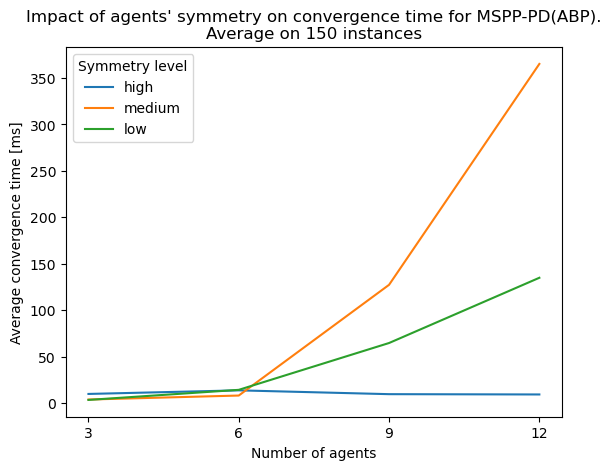

In [7]:
fig, ax = plt.subplots()
x_values = avg_convergence_times_df.columns

for symmetry_lvl in symmetry_levels:
    y_values = 1000 * avg_convergence_times_df.loc[symmetry_lvl]  # [ms]
    ax.plot(x_values, y_values, label=symmetry_lvl)

# plot finalization
ax.set_xticks(x_values)
ax.set_xlabel("Number of agents")

ax.set_ylabel("Average convergence time [ms]")

ax.set_title(
    f"Impact of agents' symmetry on convergence time for MSPP-PD(ABP).\nAverage on {num_instances} instances")
ax.legend(title="Symmetry level")

plt.show()


Interestingly, if all agents have the same source and terminus nodes, the MSPP-PD(ABP) require more or less the same time to be solved independently on the number of agents that has to be routed.

About the relationship between average convergence time and symmetry of the MSPP-PD(ABP) we can state:

- If all agents start from the same source node and end in the same terminus node, the problem size does not change significantly the average convergence time;

- If source node and terminus node of agents follows a more sophisticated pattern as the one described in the paper then the average convergemce time increase quickly with the problem size;

- If all agent source nodes and terminus nodes are selected randomly from the first and last network columns respectively, the average convergence time still increase with the problem size, but slower respect the previous case.


## A possible real case application

In this section we will see a possible application of the MSPP-PD other than those reported in the paper.


Assume to have a facility where humans and $K$ robots work together.  
Robots have to move on predefined traks marked on the floor, this tracks form a $(m \times n)$ grid-like system. Each grid's link has 2 direction of travel and if 2 robots follow opposite directions on the same link there is no risk of head-on collision. On the other hand if more robots follow the same direction on the same link, collisions may occur. Each of them has to reach some terminus location in one of the crossroads of the track grid inside the plant where is required to perform some task.  
We want to find the shortest path to the terminus location for each robot minimizing both the risk of robot-robot and human-robot collision.  

This problem can be solved as a MSPP-PD one, below we'll see how with an example


Assume that tracks' grid has size $(10 \times 10)$


In [4]:
num_horiz_tracks, num_vert_tracks = 10, 10


We label with a number each crossroad of the grid. This points will form the nodes of the network on which we'll formulate the MSPP-PD and represent possible starting or ending robot locations


In [5]:
facility_network_nodes = np.arange(num_horiz_tracks * num_vert_tracks)
facility_nodes_grid = facility_network_nodes.reshape(
    num_vert_tracks, num_horiz_tracks).T

facility_nodes_grid


array([[ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90],
       [ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91],
       [ 2, 12, 22, 32, 42, 52, 62, 72, 82, 92],
       [ 3, 13, 23, 33, 43, 53, 63, 73, 83, 93],
       [ 4, 14, 24, 34, 44, 54, 64, 74, 84, 94],
       [ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95],
       [ 6, 16, 26, 36, 46, 56, 66, 76, 86, 96],
       [ 7, 17, 27, 37, 47, 57, 67, 77, 87, 97],
       [ 8, 18, 28, 38, 48, 58, 68, 78, 88, 98],
       [ 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]])

The arcs of our network will be formed by the directed links of the grid.  
Their weights will indicate how much human-congestioned is a particular link so that while solving the MSPP-PD we'll penalize robot paths that traverse areas full of human workers in order to avoid possible accidents between them and robots


In [6]:
def get_facility_instance(network_nodes_grid, weight_func):
    """Gets a list of weighted arcs for the network that represent the robots' traks of the facility

    Args:
        network_nodes_grid (np.ndarray): The grid with the labeled crossroads of the facility
        weight_func (function): Function to compute the weights of the arc.
          Notice that weights are computed based on their location on the grid
          not on the node labels they connect

    Returns:
        list: a list of WArc representing the arcs of the facility network
    """

    # in the following we consider the location of an arc to be exactly in between the 2 nodes that is connecting
    num_rows, num_cols = network_nodes_grid.shape

    weast_to_east_arcs = ((network_nodes_grid[i, j], network_nodes_grid[i, j+1], weight_func(i, j+1/2, num_rows, num_cols))
                          for j in range(num_cols-1) for i in range(num_rows))

    east_to_west_arcs = ((network_nodes_grid[i, j+1], network_nodes_grid[i, j], weight_func(i, j+1/2, num_rows, num_cols))
                         for j in range(num_cols-1) for i in range(num_rows))

    north_to_south_arcs = ((network_nodes_grid[i, j], network_nodes_grid[i+1, j], weight_func(i+1/2, j, num_rows, num_cols))
                           for j in range(num_cols) for i in range(num_rows-1))

    south_to_north_arcs = ((network_nodes_grid[i+1, j], network_nodes_grid[i, j], weight_func(i+1/2, j, num_rows, num_cols))
                           for j in range(num_cols) for i in range(num_rows-1))

    all_arcs = chain(weast_to_east_arcs, east_to_west_arcs,
                     north_to_south_arcs, south_to_north_arcs)

    return [dg.WArc(i, j, w, idx) for idx, (i, j, w) in enumerate(all_arcs)]


For our example we suppose that that most of the work carried out by humans has to be performed at the center of the plant.  


In [7]:
def congested_center_weigth_func(x, y, num_horiz_tracks, num_vert_tracks):
    """Arc weighting function.

    The weights follow a gaussian bell centered on the center of the network.
    This function is used to weight an arc of the facility network.

    Args:
        x (float): vertical location of the arc on the grid.
        y (float): horizontal location of the arc on the grid
        num_horiz_tracks (int): number of horizontal robots' tracks in the facility
        num_vert_tracks (int): number of vertical robots' tracks in the facility

    Returns:
        float: The weight of the arc located at (x,y) on the network facility
    """

    x_term = (x - ((num_horiz_tracks-1)/2))**2 / \
        (2 * ((num_horiz_tracks-1)/6)**2)
    y_term = (y - ((num_vert_tracks-1)/2))**2 / \
        (2 * ((num_vert_tracks-1)/6)**2)
    return 1.5 * math.exp(-(x_term+y_term)) + 1


We could also have an idea on how arcs weight change along the facility with a plot


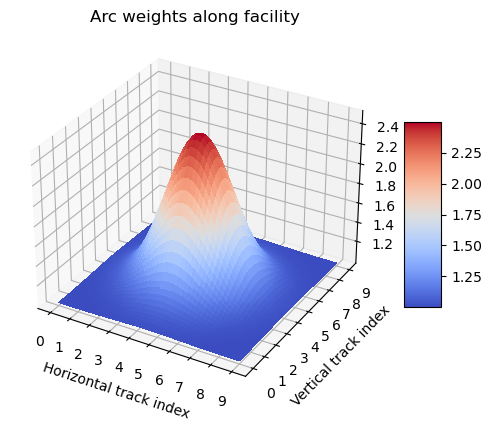

In [8]:
x = np.linspace(0, num_horiz_tracks-1, 100)
y = np.linspace(0, num_vert_tracks-1, 100)
X, Y = np.meshgrid(x, y)

Z = np.vectorize(congested_center_weigth_func)(
    X, Y, num_horiz_tracks, num_vert_tracks)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('Horizontal track index')
plt.xticks(range(num_horiz_tracks))
ax.set_ylabel('Vertical track index')
plt.yticks(range(num_vert_tracks))
ax.set_title('Arc weights along facility')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


Now we can generate the arcs for our example


In [9]:
facility_network_arcs = get_facility_instance(
    facility_nodes_grid, congested_center_weigth_func)


Robots are the agents that has to be routed in our MSPP-PD.  
For our example we assume:
- of having to route 8 different robots;
- that they are, at the beginning, scattered within the facility;
- that each one has to reach different (random) locations where they have to perform tasks.


In [10]:
def generate_random_agents(network_nodes, num_of_agents):
    '''Generate a number of Agents with random sources and termini on a network

    Used to generate the robots that has to be routed in the facility example

    Args:
        network_nodes (np.ndarray): a list containing the nodes of the network
        num_of_agents (int): number of agents to be generated

    Returns:
        list: a list of Agents with random source and terminus nodes
    '''

    agent_idxs = list(range(num_of_agents))
    agents = []

    while agent_idxs:
        agent_source = random.choice(network_nodes)
        agent_terminus = random.choice(network_nodes)
        if agent_source != agent_terminus:
            agents.append(
                dg.Agent(agent_source, agent_terminus, agent_idxs.pop(0)))

    return agents


Generate agents


In [11]:
# generate agents for our  example
random.seed(0)
num_of_agents = 8
robots = generate_random_agents(facility_network_nodes, num_of_agents)


Now everything is ready to define the arcs of our instance and to formulate the MSPP-PD problem for our practical scenario.  
For simplicity we choose the version with the arc binary penalization, but other versions would have been fine too.  
Notice also that `pm.set_problem()` gives equal weight to both distance and penalty objectives.


In [12]:
facility_pb, X, *_ = pm.set_problem("ABP",
                                    facility_network_nodes,
                                    facility_network_arcs,
                                    robots)


Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-10


Now we can solve the problem...


In [13]:
facility_pb.optimize()


And plot the solution if the optimum is found


In [14]:
print("Result of the optimization is:")
if facility_pb.Status == 2:
    print("optimal")
elif facility_pb.Status == 3:
    print("infeasible")
elif facility_pb.Status == 5:
    print("unbounded")
else:
    print("Some other return status")


Result of the optimization is:
optimal


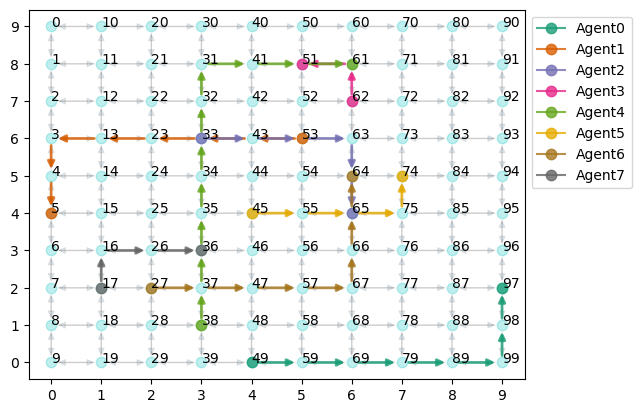

In [15]:
dv.plot_solution(X.x, facility_nodes_grid, facility_network_arcs, robots)


In [16]:
n_objectives = facility_pb.NumObj

print("Optimal solution is such that:")
obj_tot_value = 0
for obj_n in range(n_objectives):
    facility_pb.params.ObjNumber = obj_n
    obj_tot_value = obj_tot_value + facility_pb.ObjNWeight*facility_pb.ObjNVal
    print(f" {facility_pb.ObjNName}={facility_pb.ObjNVal} ", end="|")
print(f" Weighted Total={obj_tot_value}")

Optimal solution is such that:
 Distance=62.247895308204974 | Penalty=0.0 | Weighted Total=62.247895308204974
